<a href="https://colab.research.google.com/github/RVijayChiranjithReddy/Fake_face_detection/blob/main/AMTEN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
from cv2 import resize
from os import path, listdir
from imutils import paths
import numpy as np
import random
import os
import cv2

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90, horizontal_flip=True,  validation_split = 0.2 )
#train_it = train_datagen.flow_from_directory( '/content/drive/MyDrive/Minor_project/dataset/', target_size=(128, 128), batch_size=32, subset = 'training')
#val_it = train_datagen.flow_from_directory( '/content/drive/MyDrive/Minor_project/dataset/', target_size=(128, 128), batch_size=32, subset= 'validation')



In [ ]:
data = []
labels = []
i = 0
imagePaths = sorted(list(paths.list_images('/content/drive/MyDrive/data1/train')))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  labels.append(label)

(trainX, valX, _, _) = train_test_split(imagePaths,labels, test_size=0.2, random_state=42)
labels = []
for imagePath in trainX:
  print("Loading image:", i)
  i = i + 1
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (128, 128))
  data.append(image)
  label = imagePath.split(os.path.sep)[-2]
  labels.append(label)

In [ ]:
trainX = np.array(data, dtype="float") / 255.0
trainY = np.array(labels)

In [ ]:
data = []
labels = []

In [ ]:
valY = []
for imagePath in valX:
  print("Loading image:", i)
  i = i + 1
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (128, 128))
  data.append(image)
  label = imagePath.split(os.path.sep)[-2]
  valY.append(label)

In [ ]:
valX = np.array(data, dtype="float") / 255.0
valY = np.array(valY)

In [ ]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
valY = lb.transform(valY)

In [ ]:
x = layers.Input(shape=(128, 128, 3))
x1 = layers.Conv2D(3, (3, 3),padding='same')(x)
Fmt = layers.Subtract()([x1, x])
t1 = layers.Conv2D(3, (3,3), padding = 'same')(Fmt)
F1 = layers.Conv2D(3, (3,3), padding = 'same')(t1)
t2 = layers.Concatenate()([F1, Fmt])
t3 = layers.Conv2D(6, (3,3), padding = 'same')(t2)
F2 = layers.Conv2D(6, (3,3), padding = 'same')(t3)
Freu = layers.Concatenate()([F2, Fmt, t2])
print(Freu.shape)

C6 = layers.Conv2D(24, (3,3), padding = 'same')(Freu)
M6 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(C6)
A6 = layers.Activation('relu')(M6)
BN6 = layers.BatchNormalization(axis=-1, momentum=0.95,epsilon=0.005)(A6)
d1 = layers.Dropout(.2)(BN6)

C7 = layers.Conv2D(48, (3,3), padding = 'valid')(d1)
M7 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(C7)
A7 = layers.Activation('relu')(M7)
BN7 = layers.BatchNormalization(axis=-1, momentum=0.95,epsilon=0.005)(A7)
print(BN7.shape)

C8 = layers.Conv2D(64, (3,3), padding = 'valid')(BN7)
M8 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(C8)
A8 = layers.Activation('relu')(M8)
BN8 = layers.BatchNormalization(axis=-1, momentum=0.95,epsilon=0.005)(A8)
d2 = layers.Dropout(.2)(BN8)
print(BN8.shape)

C9 = layers.Conv2D(128, (1,1), padding = 'valid')(d2)
M9 = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(C9)
A9 = layers.Activation('relu')(M9)

#print(A9.shape)
#t = resnet(Freu)
t4 = layers.Flatten()(M9)
FC1 = layers.Dense(300)(t4)
FC2 = layers.Dense(300)(FC1)
FC3 = layers.Dense(1, activation = 'sigmoid')(FC2)
model = tf.keras.Model(inputs=x, outputs=FC3)

(None, 128, 128, 15)
(None, 30, 30, 48)
(None, 13, 13, 64)


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 3)  84          input_2[0][0]                    
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 128, 128, 3)  0           conv2d_9[0][0]                   
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 3)  84          subtract_1[0][0]             

In [ ]:
import math
initial_learning_rate = 0.01
def lr_step_decay(epoch, lr):
  drop_rate = 0.5
  epochs_drop = 10.0
  return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

In [ ]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1, momentum = 0.95, decay=0.005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'], steps_per_execution = 1)
model.load_weights('/content/drive/MyDrive/model/amten/AMNET3.h5')
history = model.fit(trainX, trainY, validation_data=(valX,valY), epochs=50, batch_size = 32, verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_step_decay, verbose=1)])

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
380/380 [==============================] - 54s 53ms/step - loss: 0.6601 - accuracy: 0.7214 - val_loss: 0.4449 - val_accuracy: 0.8007
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
380/380 [==============================] - 18s 48ms/step - loss: 0.4001 - accuracy: 0.8149 - val_loss: 0.4045 - val_accuracy: 0.8135
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
380/380 [==============================] - 19s 49ms/step - loss: 0.3707 - accuracy: 0.8310 - val_loss: 0.3721 - val_accuracy: 0.8353
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
380/380 [==============================] - 19s 50ms/step - loss: 0.3564 - accuracy: 0.8397 - val_loss: 0.3601 - val_accuracy: 0.8376
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.01.
380/380 [==============================] - 18s 49ms/step - loss: 0.3423 -

In [ ]:
model.save_weights('/content/drive/MyDrive/model/amten/AMNET4.h5')

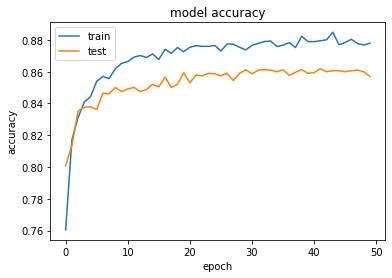

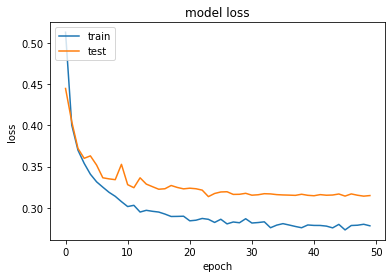

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/minor_data/accuracy.jpg', dpi=300, bbox_inches='tight')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('/content/drive/MyDrive/minor_data/loss.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.evaluate(test_it, batch_size=8, verbose=1)

85/85 [==============================] - 244s 3s/step - loss: 0.2268 - accuracy: 0.9064


[0.22682568430900574, 0.9063892960548401]

In [ ]:
model = models.load_model('/content/drive/MyDrive/minor_data/AMNET.h5')

In [ ]:
import cv2
img = cv2.imread('/content/c.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
data = np.asarray( img, dtype="int32" )
im = np.resize(data, (1, 128, 128, 3))
model.predict(im, batch_size = 1)


array([[0.11535734, 0.88464266]], dtype=float32)

In [ ]:
!pip install visualkeras

     |████████████████████████████████| 798kB 7.2MB/s 


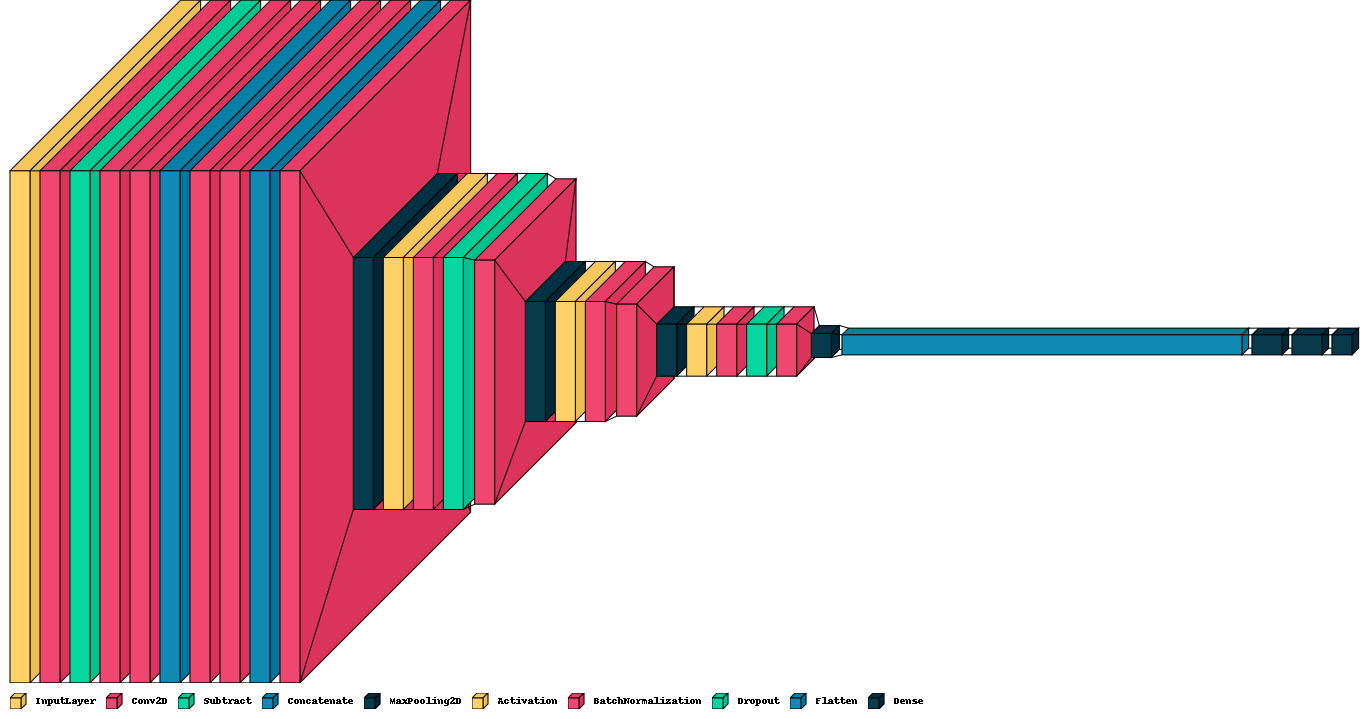

In [ ]:
import visualkeras

# visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model,legend=True, to_file='output.png') # write to disk
visualkeras.layered_view(model,legend=True, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)